# Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load dataset

In [2]:
train_df = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv")
train_demographics_df = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv")
test_df = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv")
test_demographics_df = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv")

# Check missing values

In [3]:
train_df.isnull().sum()

row_id                  0
sequence_type           0
sequence_id             0
sequence_counter        0
subject                 0
                    ...  
tof_5_v59           30142
tof_5_v60           30142
tof_5_v61           30142
tof_5_v62           30142
tof_5_v63           30142
Length: 341, dtype: int64

In [4]:
train_df.isnull().sum()[train_df.isnull().sum()>0]

rot_w         3692
rot_x         3692
rot_y         3692
rot_z         3692
thm_1         6987
             ...  
tof_5_v59    30142
tof_5_v60    30142
tof_5_v61    30142
tof_5_v62    30142
tof_5_v63    30142
Length: 329, dtype: int64

In [5]:
len(train_df)

574945

In [6]:
train_demographics_df.isnull().sum()

subject                 0
adult_child             0
age                     0
sex                     0
handedness              0
height_cm               0
shoulder_to_wrist_cm    0
elbow_to_wrist_cm       0
dtype: int64

In [7]:
len(train_demographics_df)

81

In [8]:
test_df.isnull().sum()[test_df.isnull().sum()>0]

Series([], dtype: int64)

In [9]:
test_demographics_df.isnull().sum()[test_demographics_df.isnull().sum()>0]

Series([], dtype: int64)

# Delete missing values

In [10]:
miss_columns = train_df.columns[train_df.isnull().sum()>0]

In [11]:
miss_columns

Index(['rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4',
       'thm_5', 'tof_1_v0',
       ...
       'tof_5_v54', 'tof_5_v55', 'tof_5_v56', 'tof_5_v57', 'tof_5_v58',
       'tof_5_v59', 'tof_5_v60', 'tof_5_v61', 'tof_5_v62', 'tof_5_v63'],
      dtype='object', length=329)

In [12]:
rot_columns = ["rot_w", "rot_x", "rot_y", "rot_z"]
rot_df = train_df[["sequence_id", "phase"] + rot_columns]

In [13]:
rot_df.loc[rot_df["rot_w"].isnull(), :].groupby("sequence_id").count()["phase"]

sequence_id
SEQ_001160     63
SEQ_003679     91
SEQ_004812     49
SEQ_004904     50
SEQ_006522     92
SEQ_007296     61
SEQ_007927     86
SEQ_008923     88
SEQ_009644     61
SEQ_010351     56
SEQ_011945     46
SEQ_012873     82
SEQ_013084     87
SEQ_013455     90
SEQ_014702     83
SEQ_018944    101
SEQ_019189     46
SEQ_019381    109
SEQ_019418     57
SEQ_019631     99
SEQ_019908     89
SEQ_021289     59
SEQ_022078     52
SEQ_024449     61
SEQ_027013     52
SEQ_027148     53
SEQ_027274     80
SEQ_028419     69
SEQ_028444     59
SEQ_029550    112
SEQ_033903     60
SEQ_035607     55
SEQ_037076     62
SEQ_037789     61
SEQ_038605    110
SEQ_041681     72
SEQ_043198     76
SEQ_046290     62
SEQ_050016     96
SEQ_050171     89
SEQ_050425     92
SEQ_051633     59
SEQ_053248     52
SEQ_055111     68
SEQ_055233     61
SEQ_055964     96
SEQ_057477     93
SEQ_058092     64
SEQ_061727     67
SEQ_063929    114
Name: phase, dtype: int64

In [14]:
# thermometer columns
thm_columns = ["thm_1", "thm_2", "thm_3", "thm_4", "thm_5"]
phases = train_df["phase"].unique()
thm_df = train_df[thm_columns + ["phase", "sequence_id"]]

In [15]:
thm_df.loc[thm_df["thm_1"].isnull(), :].groupby("sequence_id").count()["phase"]

sequence_id
SEQ_000389    67
SEQ_000993    53
SEQ_001905    60
SEQ_002559    79
SEQ_003071    47
              ..
SEQ_060392    69
SEQ_061589    70
SEQ_063872    64
SEQ_064578    52
SEQ_065179    60
Name: phase, Length: 104, dtype: int64

In [16]:
from itertools import product
i_list = range(1, 6)
j_list = range(64)
comb = list(product(i_list, j_list))
tof_columns = [f"tof_{i}_v{j}" for i, j in comb]
tof_df = train_df[["sequence_id", "phase"] + tof_columns]

In [17]:
tof_df.loc[tof_df["tof_1_v0"].isnull(), :].groupby("sequence_id").count()["phase"]

sequence_id
SEQ_000389    67
SEQ_000993    53
SEQ_001905    60
SEQ_002559    79
SEQ_003071    47
              ..
SEQ_060041    53
SEQ_060392    69
SEQ_061589    70
SEQ_064578    52
SEQ_065179    60
Name: phase, Length: 96, dtype: int64

These sequences have so many missing values, and it seems the missing values are continuous. Hence, we should delete all the rows that have a missing value.

In [18]:
train_df = train_df.dropna()
train_df = train_df.reset_index()

# Statistics for time-seires data

In [19]:
acc_columns = ["acc_x", "acc_y", "acc_z"]
train_df.groupby(["sequence_id"])[acc_columns].describe().transpose()

sequence_id  SEQ_000007  SEQ_000008  SEQ_000013  SEQ_000016  SEQ_000018  \
acc_x count   57.000000   68.000000   53.000000   61.000000   54.000000   
      mean     6.153098    3.400506   -7.058962    5.524654    5.363715   
      std      1.334155    1.087142    1.295184    1.074108    1.627637   
      min      3.613281    1.734375   -9.250000    3.437500    1.964844   
      25%      5.566406    2.536133   -8.136719    4.703125    5.756836   
      50%      6.488281    3.437500   -7.144531    5.390625    6.101562   
      75%      6.988281    4.414062   -6.222656    6.234375    6.322266   
      max      9.015625    5.906250   -3.347656    9.378906    6.832031   
acc_y count   57.000000   68.000000   53.000000   61.000000   54.000000   
      mean     3.915570    5.311179    2.346182   -4.408491    4.109737   
      std      3.048287    3.268073    2.564639    0.598318    3.525304   
      min     -2.019531   -0.222656   -3.273438   -5.718750   -3.164062   
      25%      3.531250    0.546875    2.156250   -4.835938    3.804688   
      50%      5.488281    7.000000    3.382812   -4.492188    6.007812   
      75%      5.984375    7.785156    3.917969   -3.878906    6.208984   
      max      6.519531    8.667969    4.683594   -2.960938    6.718750   
acc_z count   57.000000   68.000000   53.000000   61.000000   54.000000   
      mean     5.577782    6.581629   -6.068544   -3.162077    5.937066   
      std      2.337517    2.475402    1.330784    6.139752    2.104544   
      min      1.093750    1.722656  -10.945312   -8.078125    4.148438   
      25%      3.660156    4.470703   -6.617188   -7.390625    4.426758   
      50%      4.964844    5.839844   -5.851562   -6.667969    4.761719   
      75%      6.875000    9.590820   -5.277344    5.937500    7.412109   
      max      9.792969   11.074219   -3.515625    8.355469    9.933594   

sequence_id  SEQ_000022  SEQ_000033  SEQ_000034  SEQ_000046  SEQ_000053  ...  \
acc_x count  159.000000   56.000000   40.000000   78.000000   50.000000  ...   
      mean     8.020686   -4.506696   -6.922266   -8.715194    3.169062  ...   
      std      3.024375    5.093991    1.051026    0.919735    2.895546  ...   
      min      0.777344   -9.445312   -8.152344  -12.789062   -0.816406  ...   
      25%      6.310547   -7.915039   -7.556641   -8.886719    1.337891  ...   
      50%      9.746094   -7.130859   -7.173828   -8.523438    2.039062  ...   
      75%      9.777344   -1.681641   -6.407227   -8.247070    4.029297  ...   
      max      9.890625    7.562500   -2.632812   -5.742188   11.253906  ...   
acc_y count  159.000000   56.000000   40.000000   78.000000   50.000000  ...   
      mean    -0.503022   -1.683036   -6.202344    1.180539    3.737578  ...   
      std      0.975726    4.428661    1.193935    3.078569    1.403699  ...   
      min     -1.875000   -7.898438   -7.363281   -3.320312   -0.351562  ...   
      25%     -1.281250   -4.623047   -6.673828   -2.132812    3.720703  ...   
      50%     -0.800781   -2.324219   -6.480469    3.117188    4.093750  ...   
      75%      0.386719   -0.630859   -5.945312    4.168945    4.437500  ...   
      max      2.492188   10.023438    0.300781    4.648438    5.703125  ...   
acc_z count  159.000000   56.000000   40.000000   78.000000   50.000000  ...   
      mean    -2.407650   -0.815499   -1.608203    1.585537   -6.863672  ...   
      std      4.072718    4.989123    2.342782    2.909312    4.779780  ...   
      min    -10.214844   -6.402344   -9.542969   -8.210938  -12.078125  ...   
      25%     -7.546875   -4.143555   -2.746094   -0.693359   -9.272461  ...   
      50%     -0.175781   -2.781250   -1.193359    1.691406   -8.650391  ...   
      75%      0.089844    0.435547    0.001953    4.429688   -7.711914  ...   
      max      0.933594   10.492188    0.796875    6.574219    6.195312  ...   

sequence_id  SEQ_065451  SEQ_065470  SEQ_065471  SEQ_065478  SEQ_065487  \
acc_x count  113.000000   61.000000   44.000000 

We can pick mean values as a feature since there is a largegap among the sequences.

In [20]:
train_df.groupby(["sequence_id"])[rot_columns].describe().transpose()

sequence_id  SEQ_000007  SEQ_000008  SEQ_000013  SEQ_000016  SEQ_000018  \
rot_w count   57.000000   68.000000   53.000000   61.000000   54.000000   
      mean     0.263574    0.243493    0.392208    0.361083    0.859159   
      std      0.069033    0.064414    0.150629    0.041568    0.034238   
      min      0.134399    0.157593    0.061157    0.277527    0.828247   
      25%      0.209961    0.195114    0.404968    0.335388    0.832962   
      50%      0.254578    0.226562    0.439514    0.352234    0.846283   
      75%      0.322571    0.319534    0.481750    0.395813    0.866196   
      max      0.379272    0.341980    0.540771    0.459045    0.925049   
rot_x count   57.000000   68.000000   53.000000   61.000000   54.000000   
      mean    -0.280817   -0.117145    0.340804   -0.728107    0.177468   
      std      0.056597    0.049384    0.182002    0.207529    0.178091   
      min     -0.442871   -0.263306    0.140991   -0.893677   -0.184204   
      25%     -0.310242   -0.163010    0.229370   -0.869934    0.193787   
      50%     -0.275757   -0.097382    0.258362   -0.857361    0.270111   
      75%     -0.231567   -0.081055    0.304016   -0.427612    0.280701   
      max     -0.204163   -0.050537    0.726501   -0.384827    0.305542   
rot_y count   57.000000   68.000000   53.000000   61.000000   54.000000   
      mean    -0.331470   -0.342327    0.800506   -0.223281   -0.352176   
      std      0.175050    0.190164    0.090017    0.156706    0.149264   
      min     -0.478027   -0.508606    0.580505   -0.368713   -0.457458   
      25%     -0.445862   -0.487549    0.804688   -0.333862   -0.440567   
      50%     -0.414978   -0.442169    0.838135   -0.315857   -0.422699   
      75%     -0.356934   -0.066544    0.854919   -0.016052   -0.398422   
      max      0.005066   -0.031555    0.881653    0.035889   -0.022644   
rot_z count   57.000000   68.000000   53.000000   61.000000   54.000000   
      mean    -0.837994   -0.875143    0.002644   -0.363684   -0.216601   
      std      0.040723    0.042626    0.164305    0.301057    0.073268   
      min     -0.914856   -0.937805   -0.406799   -0.817688   -0.367676   
      25%     -0.865662   -0.934509    0.043457   -0.786804   -0.226486   
      50%     -0.825012   -0.860046    0.066101   -0.190979   -0.181030   
      75%     -0.807617   -0.841187    0.099487   -0.150146   -0.170792   
      max     -0.757935   -0.814697    0.129761   -0.082275   -0.159668   

sequence_id  SEQ_000022  SEQ_000033  SEQ_000034  SEQ_000046  SEQ_000053  ...  \
rot_w count  159.000000   56.000000   40.000000   78.000000   50.000000  ...   
      mean     0.345264    0.489975    0.564801    0.084734    0.052451  ...   
      std      0.191963    0.173061    0.100343    0.052652    0.051809  ...   
      min      0.000916    0.012695    0.137573    0.006714    0.001526  ...   
      25%      0.065186    0.389404    0.531311    0.025894    0.014404  ...   
      50%      0.465515    0.470245    0.600372    0.090118    0.027374  ...   
      75%      0.468506    0.538483    0.613312    0.124054    0.078888  ...   
      max      0.477783    0.819397    0.639465    0.182251    0.201111  ...   
rot_x count  159.000000   56.000000   40.000000   78.000000   50.000000  ...   
      mean    -0.609041   -0.515358   -0.658456    0.583254    0.116987  ...   
      std      0.267505    0.360890    0.253689    0.253131    0.502704  ...   
      min     -0.901184   -0.776917   -0.884399   -0.936951   -0.509583  ...   
      25%     -0.638306   -0.719437   -0.735550    0.501007   -0.487503  ...   
      50%     -0.578674   -0.702972   -0.674988    0.659363    0.472443  ...   
      75%     -0.566986   -0.390305   -0.664413    0.695175    0.511597  ...   
      max      0.882019    0.540222    0.876892    0.788696    0.654907  ...   
rot_y count  159.000000   56.000000   40.000000   78.000000   50.000000  ...   
      mean    -0.405867    0.224561    0.272682   -0.050159    0.041895  ...   
    

In [21]:
train_df.groupby(["sequence_id"])[thm_columns].describe().transpose()

sequence_id  SEQ_000007  SEQ_000008  SEQ_000013  SEQ_000016  SEQ_000018  \
thm_1 count   57.000000   68.000000   53.000000   61.000000   54.000000   
      mean    28.630612   30.464309   24.522526   31.651703   28.903610   
      std      0.582076    2.709212    0.449773    4.006846    1.144503   
      min     27.696510   25.985313   24.181389   25.413513   26.533083   
      25%     28.191868   26.686181   24.244827   26.586309   28.670930   
      50%     28.635391   32.004388   24.334288   33.085690   29.368511   
      75%     28.943842   32.557960   24.454987   34.864056   29.635752   
      max     30.543730   32.870808   25.634346   36.053188   30.267483   
thm_2 count   57.000000   68.000000   53.000000   61.000000   54.000000   
      mean    29.571870   29.678206   24.367174   31.601259   29.438643   
      std      2.576799    3.885080    0.620555    4.495657    1.658719   
      min     24.558798   23.907709   23.933413   25.018881   25.795074   
      25%     30.103525   24.039652   24.048864   25.252522   29.463904   
      50%     30.701042   32.256853   24.096001   33.199348   30.102018   
      75%     31.293034   32.497092   24.205956   35.316288   30.525968   
      max     32.010178   33.100945   26.175961   36.705894   31.035217   
thm_3 count   57.000000   68.000000   53.000000   61.000000   54.000000   
      mean    28.576605   29.179852   24.892424   29.320353   27.058073   
      std      1.260533    3.074828    0.294962    3.274493    0.951421   
      min     25.907490   24.414917   24.406981   24.128819   25.127720   
      25%     28.785812   24.659366   24.699581   24.695513   26.773631   
      50%     29.123760   30.594681   24.861069   30.926516   27.350487   
      75%     29.261164   31.445001   25.082108   31.695414   27.591779   
      max     30.090014   32.316135   25.512794   33.617542   28.468761   
thm_4 count   57.000000   68.000000   53.000000   61.000000   54.000000   
      mean    29.177937   30.501325   24.930840   32.790761   27.841705   
      std      0.278147    0.976249    0.572871    3.253195    0.431424   
      min     28.592863   28.755495   24.419798   27.227589   26.827133   
      25%     28.999083   29.262028   24.577997   28.327946   27.683474   
      50%     29.124386   30.809861   24.666821   34.618870   27.972450   
      75%     29.326674   31.324106   24.894054   35.259033   28.105730   
      max     29.761480   31.613327   26.452927   35.665222   28.400864   
thm_5 count   57.000000   68.000000   53.000000   61.000000   54.000000   
      mean    27.957446   25.824221   24.733322   30.860562   31.014364   
      std      0.877846    1.165940    0.475044    3.310154    1.394629   
      min     26.047148   24.181562   24.167980   26.312038   28.282324   
      25%     27.725689   24.984485   24.453709   27.337736   30.119308   
      50%     28.181814   25.127313   24.594648   30.702021   31.771284   
      75%     28.421408   27.098516   24.710312   33.764874   31.901149   
      max     29.428299   28.054575   26.051331   35.801083   32.180752   

sequence_id  SEQ_000022  SEQ_000033  SEQ_000034  SEQ_000046  SEQ_000053  ...  \
thm_1 count  159.000000   56.000000   40.000000   78.000000   50.000000  ...   
      mean    26.139486   27.078776   27.704940   29.702544   26.907425  ...   
      std      1.137900    1.805774    1.124578    1.230164    1.122045  ...   
      min     24.241287   23.344818   26.469988   26.283052   24.307686  ...   
      25%     24.434142   26.213723   26.790415   28.614229   25.968938  ...   
      50%     26.574310   27.258757   27.242377   30.136353   27.480171  ...   
      75%     27.002468   28.340398   28.977407   30.843619   27.687921  ...   
      max     27.298582   29.724752   29.559938   31.425875   27.910816  ...   
thm_2 count  159.000000   56.000000   40.000000   78.000000   50.000000  ...   
      mean    25.173939   27.459542   28.471161   29.639334   26.127104  ...   
      std      0.542017    2.666608    0.738

There is a gap among sequences in terms of standard deviation.
We can use std of thm as a feature.

In [22]:
train_demographics_df.describe()

,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,0.518519,21.814815,0.617284,0.876543,167.993827,51.580247,25.469136
std,0.502770,10.289693,0.489078,0.331010,10.605863,4.888415,3.025254
min,0.000000,10.000000,0.000000,0.000000,135.000000,41.000000,18.000000
25%,0.000000,13.000000,0.000000,1.000000,163.000000,49.000000,24.000000
50%,1.000000,22.000000,1.000000,1.000000,170.000000,52.000000,25.000000
75%,1.000000,27.000000,1.000000,1.000000,174.000000,55.000000,27.000000
max,1.000000,53.000000,1.000000,1.000000,190.500000,71.000000,44.000000


# Visualization

## histogram

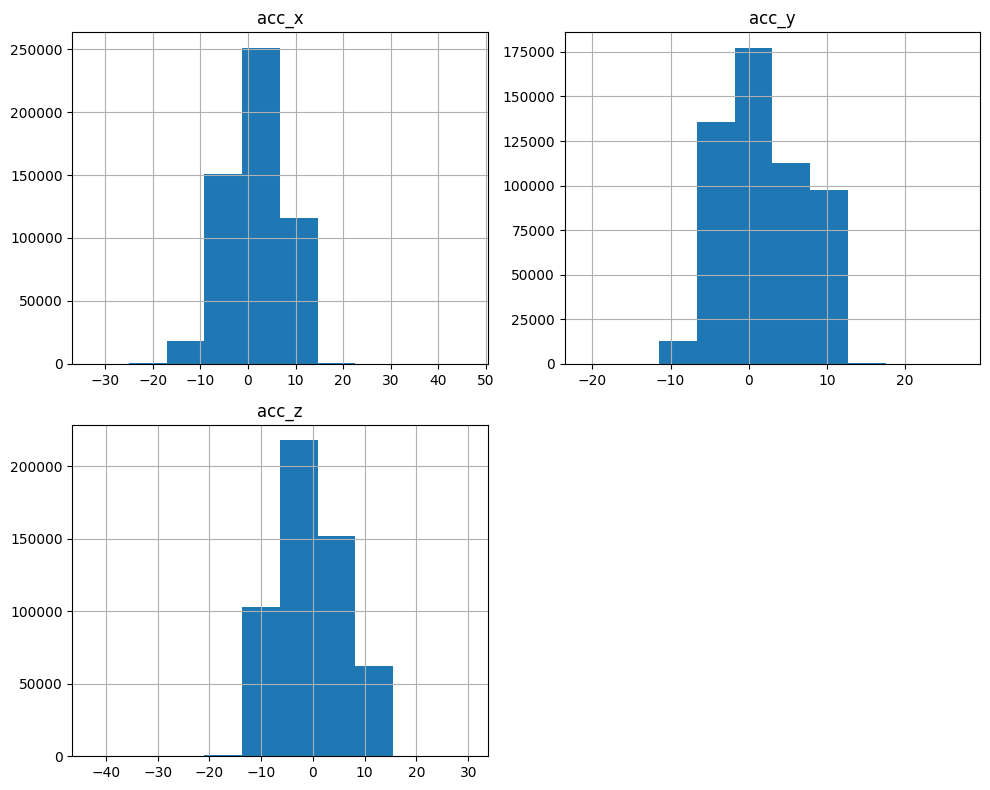

In [23]:
# acc_[x/y/z]
train_df[acc_columns].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

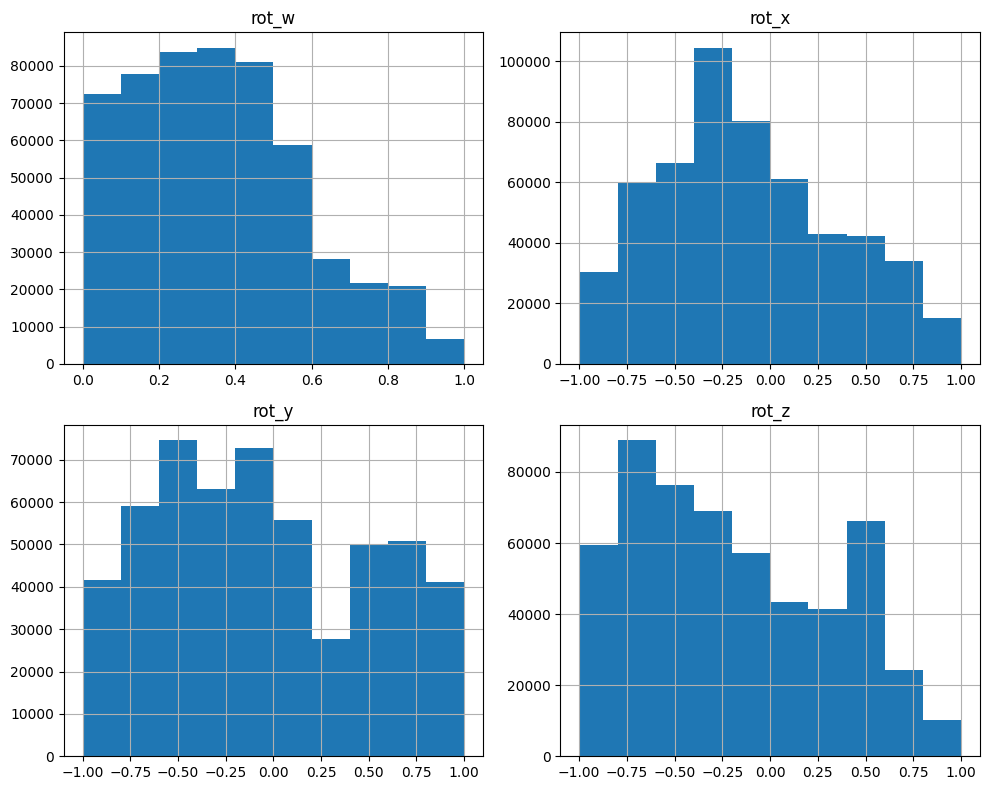

In [24]:
# rot_[w/x/y/z]
train_df[rot_columns].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

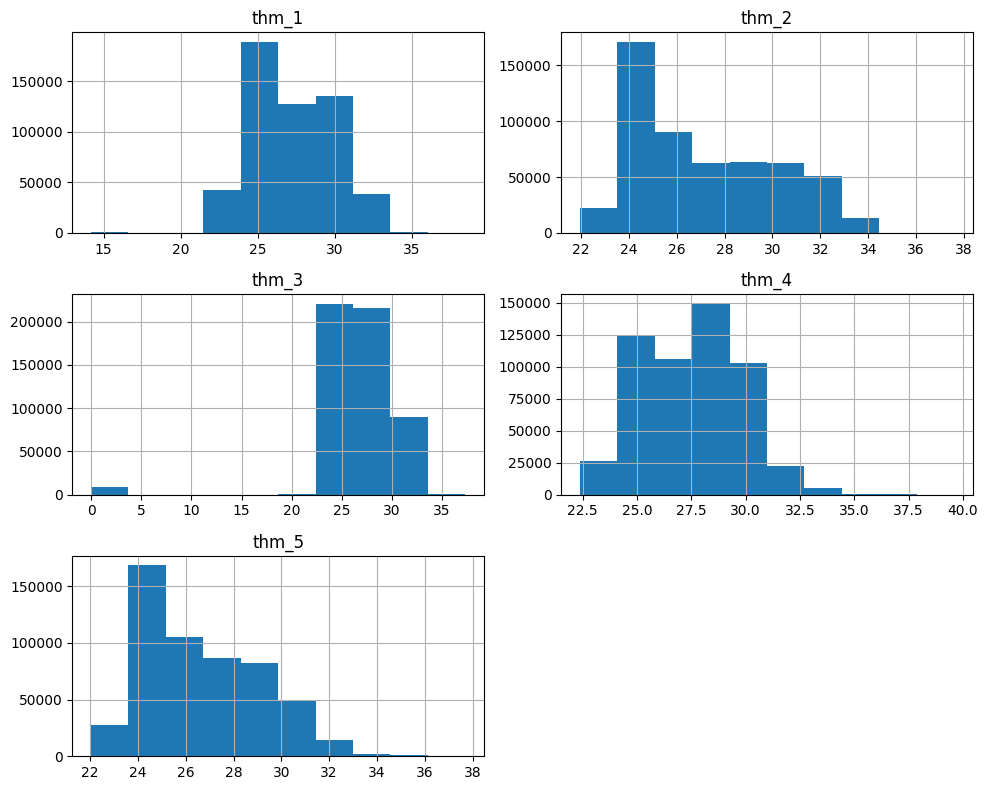

In [25]:
# thm_[1-5]
train_df[thm_columns].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

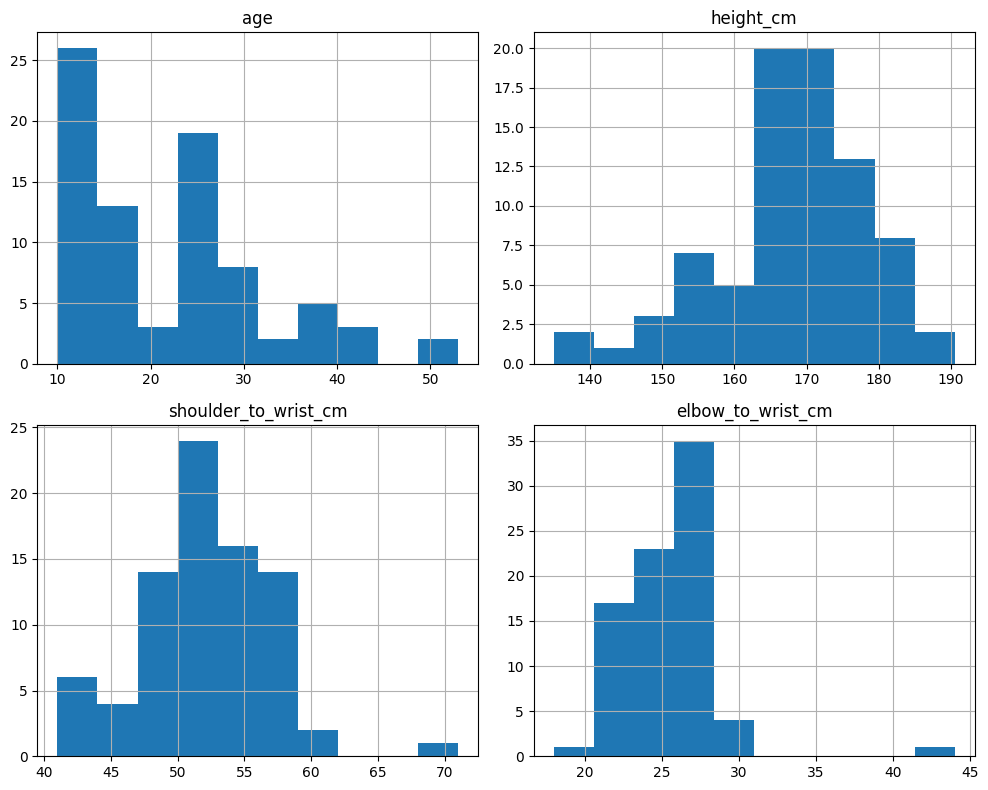

In [26]:
train_demographics_df[["age", "height_cm", "shoulder_to_wrist_cm", "elbow_to_wrist_cm"]].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

## Time-series plot

### acc

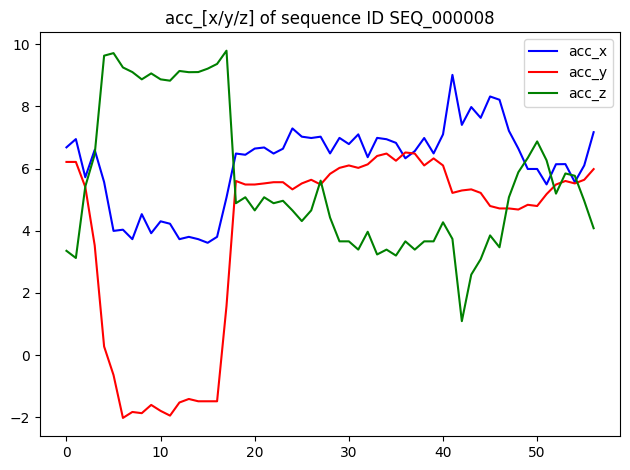

In [27]:
acc_ex1_df = train_df.loc[train_df["sequence_id"]=="SEQ_000007", acc_columns]
plt.plot(np.arange(len(acc_ex1_df)), acc_ex1_df["acc_x"], "blue", label="acc_x")
plt.plot(np.arange(len(acc_ex1_df)), acc_ex1_df["acc_y"], "red", label="acc_y")
plt.plot(np.arange(len(acc_ex1_df)), acc_ex1_df["acc_z"], "green", label="acc_z")
plt.title("acc_[x/y/z] of sequence ID SEQ_000008")
plt.legend()
plt.tight_layout()
plt.show()

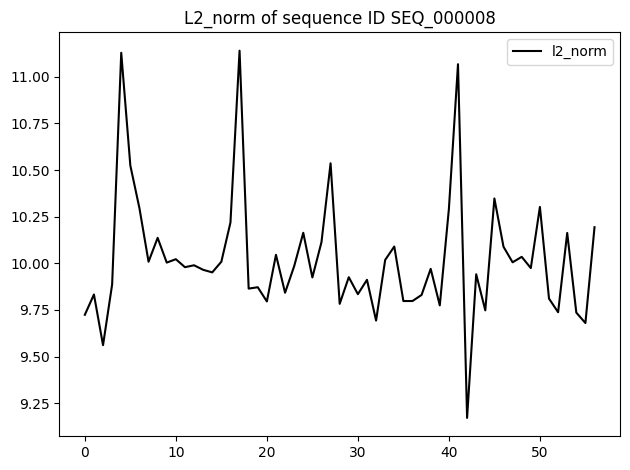

In [28]:
r = np.linalg.norm(acc_ex1_df[["acc_x", "acc_y", "acc_z"]], axis=-1, ord=2)
plt.plot(np.arange(len(acc_ex1_df)), r, "black", label="l2_norm")
plt.title("L2_norm of sequence ID SEQ_000008")
plt.legend()
plt.tight_layout()
plt.show()

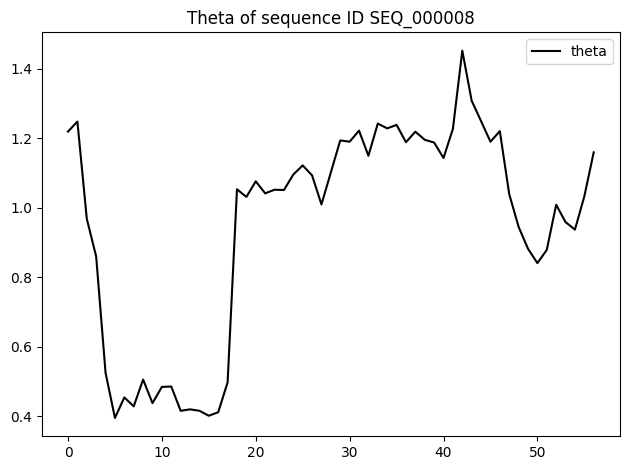

In [29]:
theta = np.arccos(acc_ex1_df["acc_z"] / r)
plt.plot(np.arange(len(acc_ex1_df)), theta, "black", label="theta")
plt.title("Theta of sequence ID SEQ_000008")
plt.legend()
plt.tight_layout()
plt.show()

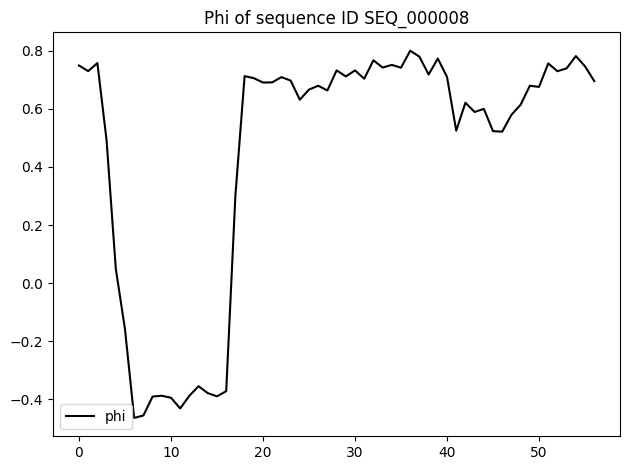

In [30]:
phi = np.arctan(acc_ex1_df["acc_y"] / acc_ex1_df["acc_x"])
plt.plot(np.arange(len(acc_ex1_df)), phi, "black", label="phi")
plt.title("Phi of sequence ID SEQ_000008")
plt.legend()
plt.tight_layout()
plt.show()

### rot

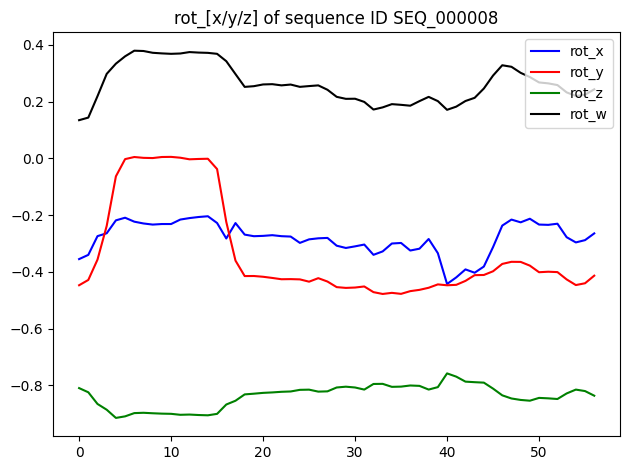

In [31]:
rot_ex1_df = train_df.loc[train_df["sequence_id"]=="SEQ_000007", rot_columns]
plt.plot(np.arange(len(rot_ex1_df)), rot_ex1_df["rot_x"], "blue", label="rot_x")
plt.plot(np.arange(len(rot_ex1_df)), rot_ex1_df["rot_y"], "red", label="rot_y")
plt.plot(np.arange(len(rot_ex1_df)), rot_ex1_df["rot_z"], "green", label="rot_z")
plt.plot(np.arange(len(rot_ex1_df)), rot_ex1_df["rot_w"], "black", label="rot_w")
plt.title("rot_[x/y/z] of sequence ID SEQ_000008")
plt.legend()
plt.tight_layout()
plt.show()

### thm

In [32]:
train_df.loc[train_df["gesture"]=="Write name on leg", "sequence_id"].unique()

array(['SEQ_000016', 'SEQ_000548', 'SEQ_000996', 'SEQ_001265',
       'SEQ_001311', 'SEQ_001760', 'SEQ_001778', 'SEQ_001904',
       'SEQ_001915', 'SEQ_002044', 'SEQ_002228', 'SEQ_002777',
       'SEQ_003180', 'SEQ_003588', 'SEQ_005524', 'SEQ_005900',
       'SEQ_006460', 'SEQ_007400', 'SEQ_007558', 'SEQ_007761',
       'SEQ_007941', 'SEQ_008140', 'SEQ_008172', 'SEQ_009059',
       'SEQ_009458', 'SEQ_011255', 'SEQ_011543', 'SEQ_011558',
       'SEQ_012349', 'SEQ_012454', 'SEQ_012923', 'SEQ_012937',
       'SEQ_013107', 'SEQ_013138', 'SEQ_013516', 'SEQ_014129',
       'SEQ_015384', 'SEQ_015406', 'SEQ_015583', 'SEQ_016262',
       'SEQ_016315', 'SEQ_017346', 'SEQ_017645', 'SEQ_017710',
       'SEQ_018170', 'SEQ_020130', 'SEQ_020325', 'SEQ_021257',
       'SEQ_021420', 'SEQ_022230', 'SEQ_022325', 'SEQ_022592',
       'SEQ_022709', 'SEQ_022991', 'SEQ_023097', 'SEQ_023416',
       'SEQ_024104', 'SEQ_024464', 'SEQ_025537', 'SEQ_026258',
       'SEQ_026476', 'SEQ_026582', 'SEQ_026727', 'SEQ_0

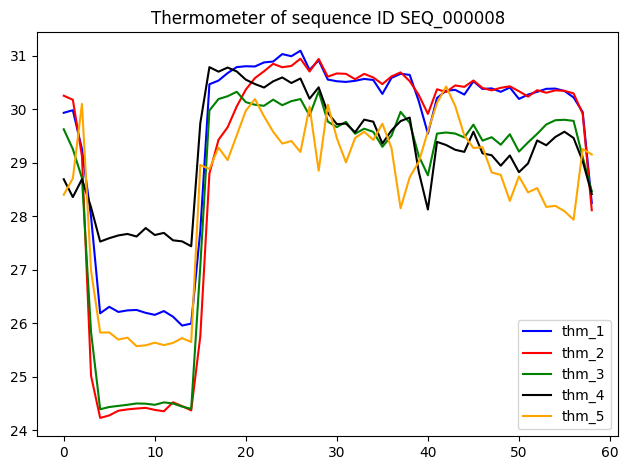

In [33]:
thm_ex1_df = train_df.loc[train_df["sequence_id"]=="SEQ_000548", thm_columns]
plt.plot(np.arange(len(thm_ex1_df)), thm_ex1_df["thm_1"], "blue", label="thm_1")
plt.plot(np.arange(len(thm_ex1_df)), thm_ex1_df["thm_2"], "red", label="thm_2")
plt.plot(np.arange(len(thm_ex1_df)), thm_ex1_df["thm_3"], "green", label="thm_3")
plt.plot(np.arange(len(thm_ex1_df)), thm_ex1_df["thm_4"], "black", label="thm_4")
plt.plot(np.arange(len(thm_ex1_df)), thm_ex1_df["thm_5"], "orange", label="thm_5")
plt.title("Thermometer of sequence ID SEQ_000008")
plt.legend()
plt.tight_layout()
plt.show()

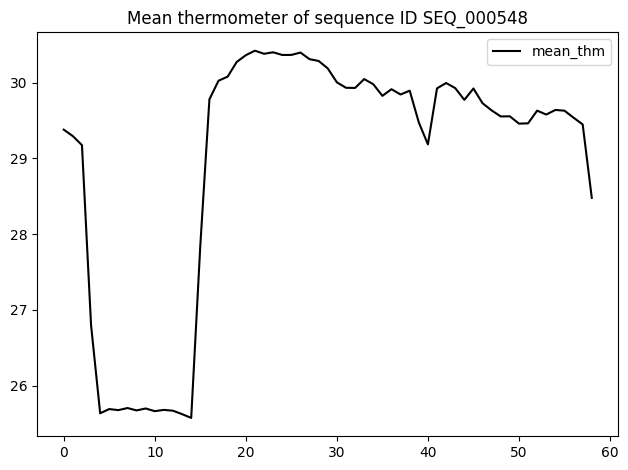

In [34]:
plt.plot(np.arange(len(thm_ex1_df)), thm_ex1_df[thm_columns].mean(axis=1), "black", label="mean_thm")
plt.title("Mean thermometer of sequence ID SEQ_000548")
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
seq_ids = train_df["sequence_id"].values
seq_counters = train_df["sequence_counter"].values
seq_starts = np.array(train_df[train_df["sequence_counter"]==0].index)
seq_lengths = np.diff(np.concatenate([seq_starts, np.array([len(train_df)])]), n=1)

seq_starts_over_50 = seq_starts[seq_lengths > 50]
seq_ids_over_50 = seq_ids[seq_starts_over_50]
seq_lengths_over_50 = seq_lengths[seq_lengths > 50]
list(seq_ids_over_50)

['SEQ_000007',
 'SEQ_000008',
 'SEQ_000013',
 'SEQ_000016',
 'SEQ_000018',
 'SEQ_000022',
 'SEQ_000033',
 'SEQ_000046',
 'SEQ_000058',
 'SEQ_000063',
 'SEQ_000079',
 'SEQ_000091',
 'SEQ_000092',
 'SEQ_000111',
 'SEQ_000113',
 'SEQ_000114',
 'SEQ_000142',
 'SEQ_000150',
 'SEQ_000169',
 'SEQ_000210',
 'SEQ_000220',
 'SEQ_000237',
 'SEQ_000239',
 'SEQ_000245',
 'SEQ_000250',
 'SEQ_000255',
 'SEQ_000259',
 'SEQ_000266',
 'SEQ_000281',
 'SEQ_000313',
 'SEQ_000320',
 'SEQ_000322',
 'SEQ_000323',
 'SEQ_000326',
 'SEQ_000331',
 'SEQ_000335',
 'SEQ_000354',
 'SEQ_000360',
 'SEQ_000365',
 'SEQ_000366',
 'SEQ_000367',
 'SEQ_000371',
 'SEQ_000386',
 'SEQ_000412',
 'SEQ_000417',
 'SEQ_000419',
 'SEQ_000430',
 'SEQ_000436',
 'SEQ_000458',
 'SEQ_000461',
 'SEQ_000492',
 'SEQ_000502',
 'SEQ_000504',
 'SEQ_000510',
 'SEQ_000517',
 'SEQ_000525',
 'SEQ_000527',
 'SEQ_000536',
 'SEQ_000546',
 'SEQ_000548',
 'SEQ_000571',
 'SEQ_000586',
 'SEQ_000589',
 'SEQ_000603',
 'SEQ_000615',
 'SEQ_000617',
 'SEQ_0006

In [56]:
seq_starts_under_50 = seq_starts[seq_lengths < 50]
seq_ids_under_50 = seq_ids[seq_starts_under_50]
seq_lengths_under_50 = seq_lengths[seq_lengths < 50]
seq_ids_under_50

array(['SEQ_000034', 'SEQ_000166', 'SEQ_000182', ..., 'SEQ_065435',
       'SEQ_065471', 'SEQ_065526'], dtype=object)

In [57]:
seq_starts_under_50

array([   508,   1376,   1503, ..., 535073, 535434, 536204])

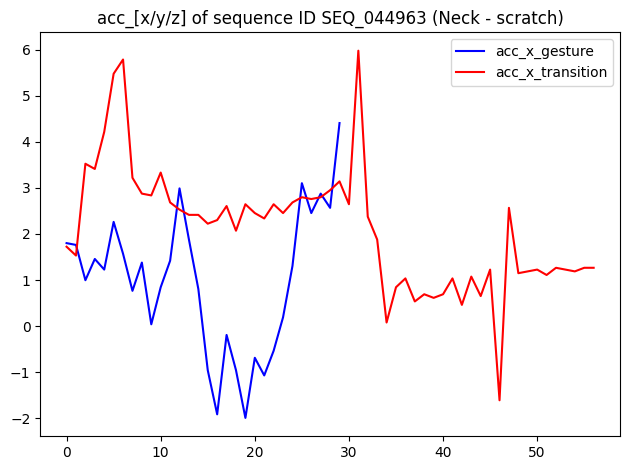

In [80]:
acc_ex1_df = train_df.loc[(train_df["sequence_id"]=="SEQ_000114") & (train_df["phase"]=="Gesture"), acc_columns]
plt.plot(np.arange(len(acc_ex1_df)), acc_ex1_df["acc_x"], "blue", label="acc_x_gesture")
acc_ex1_df = train_df.loc[(train_df["sequence_id"]=="SEQ_000114") & (train_df["phase"]=="Transition"), acc_columns]
plt.plot(np.arange(len(acc_ex1_df)), acc_ex1_df["acc_x"], "red", label="acc_x_transition")
# plt.plot(np.arange(len(acc_ex1_df)), acc_ex1_df["acc_y"], "red", label="acc_y")
# plt.plot(np.arange(len(acc_ex1_df)), acc_ex1_df["acc_z"], "green", label="acc_z")
plt.title(f"acc_[x/y/z] of sequence ID SEQ_044963 ({train_df.loc[seq_starts_over_200[15], 'gesture']})")
plt.legend()
plt.tight_layout()
plt.show()

In [73]:
train_df.loc[train_df["sequence_id"]=="SEQ_000114", 'phase']

1136    Transition
1137    Transition
1138    Transition
1139    Transition
1140    Transition
           ...    
1218       Gesture
1219       Gesture
1220       Gesture
1221       Gesture
1222       Gesture
Name: phase, Length: 87, dtype: object

# Feature engineering

## train_df
Add new columns -> polar coodinates of acc and rot, mean thm1 to thm 5  
Delete columns -> cartesian coodinates of acc and rot, (thm1 to thm5), phase, orientation, behavior  
Merge 2 DataFrames  
Encoding (category variable) ->   
Scaling  
Feature selection  
Encode target -> sequence_type (for pretraining), gesture (for fine-tuning, transfer learning)

## train_demographic_df
Scaling  
Delete -> handedness (1 accounts for 87% of the subjects)

## Add new columns

In [35]:
# Add mean and std features to original df
def add_stat_feature(df):
    acc_desc = create_acc_mean_df(df)
    thm_desc = create_thm_std_df(df)
    df = pd.merge(df, acc_desc, on="sequence_id")
    df = pd.merge(df, thm_desc, on="sequence_id")
    return df

# Create mean feature of acc
def create_acc_mean_df(df):
    acc_desc = df.groupby(["sequence_id"])[acc_columns].describe()
    acc_desc = acc_desc[[("acc_x", "mean"), ("acc_y", "mean"), ("acc_z", "mean")]]
    acc_desc.columns = acc_desc.columns.droplevel(1)
    acc_desc.columns = ["acc_x_mean", "acc_y_mean", "acc_z_mean"]
    return acc_desc

# Create std feature of thm
def create_thm_std_df(df):
    thm_desc = df.groupby(["sequence_id"])[thm_columns].describe()
    thm_desc = thm_desc[[("thm_1", "std"), ("thm_2", "std"), ("thm_3", "std"), ("thm_4", "std"), ("thm_5", "std")]]
    thm_desc.columns = thm_desc.columns.droplevel(1)
    thm_desc.columns = ["thm_1_std", "thm_2_std", "thm_3_std", "thm_4_std", "thm_5_std"]
    return thm_desc

In [36]:
def add_new_features(df, eps=1e-8, mode="train"):
    polar_acc_df = create_polar_coordinate_acc(df)
    polar_rot_df = create_polar_coordinate_rot(df, eps)
    mean_thm_df = create_mean_thm(df)
    # if mode == "train":
    #     df = delete_unnecessary_columns(df)
    df = pd.concat([df, polar_acc_df], axis=1)
    del polar_acc_df
    df = pd.concat([df, polar_rot_df], axis=1)
    del polar_rot_df
    df = pd.concat([df, mean_thm_df], axis=1)
    del mean_thm_df
    return df

def create_polar_coordinate_acc(df, eps=1e-8):
    acc_columns = ["acc_x", "acc_y", "acc_z"]
    df = df[acc_columns]
    r = np.linalg.norm(df, axis=1, ord=2)
    theta = np.arccos(df["acc_z"] / r)
    # phi = np.arctan(df["acc_y"] / df["acc_x"])
    norm_x_y = np.linalg.norm(df[["acc_x", "acc_y"]], axis=1, ord=2) + eps
    phi = np.sign(df["acc_y"]) * np.arccos(df["acc_x"] / norm_x_y)
    df["acc_r"], df["acc_theta"], df["acc_phi"] = r, theta, phi
    df = df.drop(acc_columns, axis=1)
    return df

def create_polar_coordinate_rot(df, eps=1e-8):
    rot_columns = ["rot_w", "rot_x", "rot_y", "rot_z"]
    df = df[rot_columns]
    norm = np.linalg.norm(df, axis=1, ord=2).reshape(-1, 1)
    df[rot_columns] = df / norm
    omega = 2 * np.arccos(np.clip(df["rot_w"], -1.0, 1.0))
    sin_omega_over2 = np.sqrt(1 - df["rot_w"]*df["rot_w"])
    df["rot_omega"] = omega
    ux, uy, uz = df["rot_x"] / sin_omega_over2, df["rot_y"] / sin_omega_over2, df["rot_z"] / sin_omega_over2
    ux.loc[sin_omega_over2 < eps] = 1.0
    uy.loc[sin_omega_over2 < eps] = 0.0
    uz.loc[sin_omega_over2 < eps] = 0.0
    u_theta = np.arccos(uz)
    u_phi = np.arctan(uy / ux)
    df["rot_u_theta"], df["rot_u_phi"] = u_theta, u_phi
    df = df.drop(rot_columns, axis=1)
    return df

def create_mean_thm(df):
    thm_columns = ["thm_1", "thm_2", "thm_3", "thm_4", "thm_5"]
    df = df[thm_columns]
    df["thm_mean"] = df.mean(axis=1)
    df = df.drop(thm_columns, axis=1)
    return df

def delete_acc_columns(df):
    acc_columns = ["acc_x", "acc_y", "acc_z"]
    df = df.drop(acc_columns, axis=1)
    return df

def delete_rot_columns(df):
    rot_columns = ["rot_w", "rot_x", "rot_y", "rot_z"]
    df = df.drop(rot_columns, axis=1)
    return df

def delete_thm_columns(df):
    thm_columns = ["thm_1", "thm_2", "thm_3", "thm_4", "thm_5"]
    df = df.drop(thm_columns, axis=1)
    return df

def delete_unnecessary_columns(df, drop_columns=["orientation", "behavior", "phase"]):
    df = delete_acc_columns(df)
    df = delete_rot_columns(df)
    df = delete_thm_columns(df)
    df = df.drop(drop_columns, axis=1)
    return df

In [37]:
train_df = add_new_features(train_df)
train_df = add_stat_feature(train_df)
train_df = delete_unnecessary_columns(df)

## Encode categorical values

In [38]:
train_demographics_df = train_demographics_df.drop(["handedness"], axis=1)
# test_demographics_df = test_demographics_df.drop(["handedness"], axis=1)

## Merge train_df and train_demographics_df

In [39]:
gestures = pd.get_dummies(train_df["gesture"])
gesture_columns = gestures.columns
def get_sequence_gestures(df):
    seq_ids = df["sequence_id"].values
    seq_starts = np.array(df[df["sequence_counter"]==0].index)
    sequence_gestures = df.loc[seq_starts, gesture_columns]
    return sequence_gestures

def get_seq_length_and_gesture(df):
    seq_ids = df["sequence_id"].values
    seq_counters = df["sequence_counter"].values
    seq_starts = np.array(df[df["sequence_counter"]==0].index)
    seq_lengths = np.diff(np.concatenate([seq_starts, np.array([len(df)])]), n=1)
    gestures = df["gesture"][seq_starts].values
    subjects = df["subject"][seq_starts].values
    return seq_lengths, gestures, subjects

In [40]:
lengths, gestures, subjects = get_seq_length_and_gesture(train_df)
a = pd.DataFrame({"gesture": gestures, "subject": subjects})
b = pd.merge(a, train_demographics_df, on="subject")

In [41]:
train_df = pd.merge(train_df, train_demographics_df, on="subject")
# test_df = pd.merge(test_df, test_demographics_df, on="subject")

## Scaling (Min Max Scaling)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
sc_columns = ["acc_x", "acc_y", "acc_z", "acc_r", "acc_theta", "acc_phi", 
              "rot_w", "rot_x", "rot_y", "rot_z", "rot_omega", "rot_u_theta", "rot_u_phi", 
              "thm_1", "thm_2", "thm_3", "thm_4", "thm_5", "thm_mean", 
              "acc_x_mean", "acc_y_mean", "acc_z_mean", 
              "thm_1_std", "thm_2_std", "thm_3_std", "thm_4_std", "thm_5_std",
              "age", "height_cm", "shoulder_to_wrist_cm", "elbow_to_wrist_cm"]
train_df[sc_columns] = sc.fit_transform(train_df[sc_columns])
# test_df[sc_columns] = sc.transform(test_df[sc_columns])

train_df[tof_columns] = train_df[tof_columns] / 254.0
# test_df[tof_columns] = test_df[tof_columns] / 254.0

In [ ]:
import os
output_path = "/kaggle/working/"
train_path = os.path.join(output_path, "preprocessed_train.csv")
# test_path = os.path.join(output_path, "preprocessed_test.csv")

train_df.to_csv(train_path, index=False)
# test_df.to_csv(test_path, index=False)